In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Worldometer Data

Data is from: https://www.worldometers.info/coronavirus/

I resorted to copying and pasting the data into an excel spreadsheet 'myfile.xlsx'.

In [533]:
df_cases = pd.read_excel (r'myfile.xlsx',sheet_name='cases')
df_deaths = pd.read_excel (r'myfile.xlsx',sheet_name='deaths')

# Neatening the numpy arrays of data

Data is from table with regular titles at intervals, such as 'Date' repetition (for viewing purposes on wikipedia)

Had to remove this for ease of analysis.

In [534]:
def remove_annoying_rows(array):
    counter = 0
    ignore_rows=[0,1,2]
    while counter < np.shape(array)[0]:
        row = array[counter]
        is_row_string = False
        if counter in ignore_rows:
            pass
        else:
            if type(row[0]) == datetime:
                pass
            elif str(row[0])[0] == '2':
                    pass
            elif type(row[0]) == pd.Timestamp:
                pass
            else:
                is_row_string = True
            
            if is_row_string == True:
                array = np.delete(array, (counter), axis=0)
        counter +=1 
    
    return(array)
numpy_tables_cases = remove_annoying_rows(pd.DataFrame.to_numpy(df_cases,dtype='object'))
numpy_tables_deaths = remove_annoying_rows(pd.DataFrame.to_numpy(df_deaths,dtype='object'))
print(numpy_tables_cases)

[['(local)' 'Argentina' 'Chile' ... 'Russia' 'ignore' 'International']
 [nan nan nan ... nan nan nan]
 ['20.1.10' nan nan ... nan 0 nan]
 ...
 ['20.4.01' nan nan ... nan 935232 76871]
 ['20.4.02' nan nan ... nan 1015096 79864]
 ['20.4.03' nan nan ... nan 1116662 101566]]


# Create dictionaries for datasets 

to help with indexing down the line

In [535]:
def create_dictionaryOf_indexes(data):
    dictionary = {}
    for i,country in enumerate(data[0]):
        if country == '(local)':
            pass
        elif country == 'New that day' or country == 'Sum to date':
            pass
        else:
            dictionary[str(country)] = i
    return(dictionary)

dictionary_cases_index = create_dictionaryOf_indexes(numpy_tables_cases)
dictionary_deaths_index = create_dictionaryOf_indexes(numpy_tables_deaths)

In [536]:
#create a list of problamatic countries whose names are not the same on the cases spreadsheet and deaths spreadsheet
#Extra care must be taken when analysing these countries
problomatic_countries = []
list_countries_cases = []
list_countries_deaths = []

for country in (numpy_tables_cases[0]): list_countries_cases.append(country)
for country in numpy_tables_deaths[0]: 
    list_countries_deaths.append(country)
    if country not in list_countries_cases:
        problomatic_countries.append(country)

for country in numpy_tables_cases[0]: 
    if country not in list_countries_deaths:
        problomatic_countries.append(country)



# Population of Countries

In [537]:
import requests
import lxml.html as lh
import pandas as pd

url='https://www.worldometers.info/world-population/population-by-country/'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#create dictionary for country:population
population_dictionary = {}

for T in tr_elements[1:]: population_dictionary[T[1].text_content()] = int(T[2].text_content().replace(',', '')) 
population_dictionary['International'] =  7775500000
# population_dictionary

# International data online is cumulative

So I had to convert it back to cases using below algorithm:

In [538]:
# international_data_redone = False
# def make_international_newNotCumulative(international_data_redone):
#     if international_data_redone == False:
#         cases_international = np.zeros(shape=(np.shape(numpy_tables_cases_tranpose[dictionary_cases_index.get('International')])))
#         for i,total_that_day in enumerate(numpy_tables_cases_tranpose[dictionary_cases_index.get('International')]):
#             if type(numpy_tables_cases_tranpose[dictionary_cases_index.get('International')][i-1]) == int and type(total_that_day) == int:
#                 previous_days_total = numpy_tables_cases_tranpose[dictionary_cases_index.get('International')][i-1]
#                 new_cases_thatDay = total_that_day - previous_days_total
#                 cases_international[i] = int(new_cases_thatDay)

#         numpy_tables_cases_tranpose[dictionary_cases_index.get('International')][2:] = cases_international[2:]
        
#         deaths_international = np.zeros(shape=(np.shape(numpy_tables_deaths_tranpose[dictionary_deaths_index.get('International')])))
#         for i,total_that_day in enumerate(numpy_tables_deaths_tranpose[dictionary_deaths_index.get('International')]):
#             if type(numpy_tables_deaths_tranpose[dictionary_deaths_index.get('International')][i-1]) == int and type(total_that_day) == int:
#                 previous_days_total = numpy_tables_deaths_tranpose[dictionary_deaths_index.get('International')][i-1]
#                 new_deaths_thatDay = total_that_day - previous_days_total
#                 deaths_international[i] = int(new_deaths_thatDay)

#         numpy_tables_deaths_tranpose[dictionary_deaths_index.get('International')][2:] = deaths_international[2:]
        
#         international_data_redone = True
#         return(numpy_tables_cases_tranpose,numpy_tables_deaths_tranpose)
# numpy_tables_cases_tranpose,numpy_tables_deaths_tranpose = make_international_newNotCumulative(international_data_redone)

# numpy_tables_cases,numpy_tables_deaths = numpy_tables_cases_tranpose.T,numpy_tables_deaths_tranpose.T

In [539]:
# numpy_tables_cases.T[-1][2:] = differentiate(yvals_cases)[-1]
# print(numpy_tables_deaths.T[-1][3:], differentiate(yvals_deaths)[-1])
# numpy_tables_deaths.T[-1][3:] = differentiate(yvals_deaths)[-1]

# Producing cumulative data


In [540]:
def produce_cumulative_data(array):
    '''produce numpy array with structure:
            date1 date2 date3 date4 date5 ... dateToday
    country1: 0     0     1     2     5
    country2: 0     1     7     19    60  etc.
    country3:
    ...
    countryN
    '''
    
    
    index_length = np.shape(array)[1]
    previous_cases = np.zeros(shape = (np.shape(array)[1]),dtype=int)
    dates_ = np.zeros(shape=(1,np.shape(array)[0]),dtype = 'object')
    yvals_ = np.zeros(shape=(np.shape(array)),dtype = 'object').T
    

    for i,date_point in enumerate(array):
        if type(date_point[0]) != float:
            if date_point[0][0] == '2':
                for letter in range(len(date_point[0])):
                    if date_point[0][letter] == '.': 
                        date_point[0] = date_point[0][:letter]+'-'+date_point[0][letter+1:]
                for letter in range(1,len(date_point[0])-1):
                    if date_point[0][letter-1] == '-' and date_point[0][letter+1] == '-':
                        date_point[0] = date_point[0][:letter] + '0' + date_point[0][letter:]

                date = datetime.strptime(date_point[0], '%y-%m-%d')
                number_cases = np.zeros((len(array[0])))
                for j in range(index_length):
                    if type(date_point[j]) == int:
                        if type(previous_cases[i]) == np.int32:
                            number_cases[j] = int(date_point[j] + previous_cases[j])
                            previous_cases[j] = int(number_cases[j])

                        elif previous_cases[j] == 0:
                            number_cases[j] = date_point[j]
                            previous_cases[j] = int(number_cases[j])
                    else:
                        number_cases[j] = previous_cases[j]
                    yvals_[j][i] = number_cases[j]                                            
                dates_[0][i] = date 
    dates_ = dates_[0]
    
    columns_to_be_deleted = []
    for j,day in enumerate(dates_):
        if day == 0:
            columns_to_be_deleted.append(j)

    dates_ = np.delete(dates_,columns_to_be_deleted,0)
    yvals_ = np.delete(yvals_,columns_to_be_deleted,1)
    print('date range :', dates_[0],'to: ',dates_[-1])

    
    return(dates_,yvals_)
                
dates_cases,yvals_cases = produce_cumulative_data(numpy_tables_cases)
dates_deaths,yvals_deaths = produce_cumulative_data(numpy_tables_deaths)




date range : 2020-01-10 00:00:00 to:  2020-04-03 00:00:00
date range : 2020-01-21 00:00:00 to:  2020-04-03 00:00:00


# Fatality rate data for ROW

In [541]:
def find_index_forDate(date_to_be_indexed,cases_or_deaths):
    '''finds index for given date'''
    
    if cases_or_deaths == 'cases':
        for i,date in enumerate(dates_cases):
            if date == date_to_be_indexed:
                return(i)
    elif cases_or_deaths == 'deaths':
        for i,date in enumerate(dates_deaths):
            if date == date_to_be_indexed:
                return(i)
            

def find_countryName_fromIndex(index,cases_or_deaths):
    if cases_or_deaths == 'cases':
        for country_name in dictionary_cases_index:
            if dictionary_cases_index.get(country_name) == index:
                return(country_name)
    elif cases_or_deaths == 'deaths':
        for country_name in dictionary_deaths_index:
            if dictionary_deaths_index.get(country_name) == index:
                return(country_name)

        
def produce_fatality_rate(percentage = True):
    '''creates array with same dimensions as deaths array'''
    fatality_rates = np.zeros(shape=(np.shape(yvals_deaths)),dtype = float)
    
    
    for i,country in enumerate(yvals_deaths):
        if find_countryName_fromIndex(i,'deaths') is not None:
            country_string = find_countryName_fromIndex(i,'deaths')
            if country_string in dictionary_deaths_index and country_string in dictionary_cases_index:
                index_for_casesArray = dictionary_cases_index.get(country_string)
                for j,date in enumerate(dates_deaths):
                    index_fordate_inCases = find_index_forDate(date,'cases') #probably couldve done this earlier on to prevent it being done everytime this function iterates for each country
                    if yvals_cases[index_for_casesArray,index_fordate_inCases] != 0:
                        fatality_rates[i,j] = 100*yvals_deaths[i,j]/yvals_cases[index_for_casesArray,index_fordate_inCases]
    return(fatality_rates)          

yvals_fatality_rates = produce_fatality_rate()

# Differentiation algorithm

In [542]:
def differentiate(yvalues,time_periodInDays=1):
    yvals = np.zeros(shape=(np.shape(yvalues)),dtype = float)
    for i,country in enumerate(yvalues):
        for j,value_on_date in enumerate(country):
            if j != 0:   
                yvals[i,j] = (yvalues[i,j] - yvalues[i,j-1])/time_periodInDays
    return(yvals)

# Exponential algorithm

In [543]:
def exponential(yvalues):
    yvals = np.zeros(shape=(np.shape(yvalues)),dtype = float)
    for i,country in enumerate(yvalues):
        for j,value_on_date in enumerate(country):
            if j!= 0:
                yvals[i,j] = (yvalues[i,j] - yvalues[i,j-1])/yvalues[i,j]
    return(yvals)

# Divide all values by population algorithm

In [544]:
def divide_by_population(yvalues,cases_or_deaths):
    index_dictionary = {}
    if cases_or_deaths == 'cases': index_dictionary = dictionary_cases_index
    elif cases_or_deaths == 'deaths': index_dictionary = dictionary_deaths_index
    new_yvalues = np.zeros(shape=(np.shape(yvalues)),dtype = float)
        
    for index,country in enumerate(yvalues):
        new_yvalues[index] = country
        population = 0
        country_name = find_countryName_fromIndex(index,cases_or_deaths)
        if country_name and country_name not in problomatic_countries:
            population = population_dictionary[find_countryName_fromIndex(index,cases_or_deaths)]
            new_yvalues[index] /= population
    
    return(new_yvalues)

# yvals = 100*divide_by_population(yvals_cases,'cases')
yvals = yvals_cases
yvals[dictionary_cases_index.get('International')]


array([0.0, 41.0, 41.0, 41.0, 41.0, 41.0, 45.0, 62.0, 121.0, 199.0, 291.0,
       440.0, 580.0, 845.0, 1317.0, 2015.0, 2800.0, 4581.0, 6058.0,
       7813.0, 9823.0, 11950.0, 14553.0, 17391.0, 20630.0, 24545.0,
       28266.0, 31439.0, 34876.0, 37552.0, 40553.0, 43099.0, 45134.0,
       59287.0, 64438.0, 67100.0, 69197.0, 71329.0, 73332.0, 75184.0,
       75700.0, 76677.0, 77673.0, 78651.0, 79205.0, 80087.0, 80828.0,
       81820.0, 83112.0, 84615.0, 86604.0, 88585.0, 90443.0, 93016.0,
       95314.0, 98425.0, 102050.0, 106099.0, 109991.0, 114381.0, 118948.0,
       126214.0, 134509.0, 145416.0, 156475.0, 169511.0, 182431.0,
       198159.0, 218744.0, 244902.0, 275550.0, 304979.0, 337459.0,
       378830.0, 422574.0, 471035.0, 531865.0, 596366.0, 663127.0,
       723390.0, 784741.0, 858361.0, 935232.0, 1015096.0, 1116662.0],
      dtype=object)

# Plotting the data

In [572]:
import matplotlib as lib
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.style
style = 'seaborn'


def plot(type_of_plot,countries_list,cases_or_deaths,date_min_index=0,date_max_index=None,timeshift=None,divideBy_population=False,style=style):
    '''Different types of plot are: cumulative, new, acceleration,exponential,fatality rate.  
    timeshift is in days and always applies to UK'''
    
    #  check of input
    assert(type(countries_list) == list)
    if divideBy_population == True:
        assert(type_of_plot != 'exponential' and type_of_plot != 'fatality rate'), 'doesnt make sense to divide by population for plot of: '+type_of_plot
    for country in countries_list:
        if type_of_plot == 'fatality rate': assert(country not in problomatic_countries), 'The country ' + str(country) + 'is problomatic'
        if cases_or_deaths =='cases':
            assert(country in dictionary_cases_index), str(country) + ' is not in ' + str(dictionary_cases_index)
        elif cases_or_deaths == 'deaths':
            assert(country in dictionary_deaths_index), str(country) + ' is not in ' + str(dictionary_deaths_index)
    if type_of_plot == 'fatality rate': assert(cases_or_deaths == None), 'Fatality rate requires argument "cases_or_deaths_" = None, but currently inputed as: ' + str(cases_or_deaths)
     
    #  setup stuff
    with plt.style.context(style):
        fig, ax = plt.subplots(num=style)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)


    ax.grid(True)
    ###### title stuff #####
    end_title = ''
    if timeshift:
        end_title += ' with UK shifted back by ' +str(timeshift) + 'days'
    if divideBy_population == True:
        end_title += ' divided by population'
        ax.set_ylabel('percentage of population')  
    
    if type_of_plot  == 'fatality rate':
        ax.title.set_text(str(type_of_plot))
        ax.set_ylabel('percentage deaths/cases')
    elif type_of_plot == 'new':
        ax.title.set_text('plot of new ' + str(cases_or_deaths) + ' each day' + end_title)
        if divide_by_population == True:
            ax.set_ylabel('percentage cases/population')
    elif timeshift is not None:
        ax.title.set_text(str(type_of_plot) + ' plot of ' + str(cases_or_deaths) + end_title)
    elif type_of_plot == 'exponential':
        ax.set_ylabel('Time Constant')
        ax.title.set_text(str(type_of_plot) + ' plot of ' + str(cases_or_deaths))
    elif divideBy_population == True:
        ax.set_ylabel('percentage of population')
        ax.title.set_text(str(type_of_plot) + ' plot of ' + str(cases_or_deaths) + end_title)
    else:
        ax.title.set_text(str(type_of_plot) + ' plot of ' + str(cases_or_deaths) + end_title)
    ##### title stuff #####
    
    #  define dates and yvals for each case
    if cases_or_deaths == 'cases':
        if type_of_plot == 'cumulative':
            dates,yvals = dates_cases,yvals_cases
        elif type_of_plot == 'new':
            dates,yvals = dates_cases,differentiate(yvals_cases)
        elif type_of_plot == 'acceleration':
            dates,yvals = dates_cases,differentiate(differentiate(yvals_cases))
        elif type_of_plot == 'exponential':
            dates,yvals = dates_cases,exponential(yvals_cases)
        else:
            raise ValueError('type_of_plot is not inputed correctly')
    
    elif cases_or_deaths == 'deaths':
        if type_of_plot == 'cumulative':
            dates,yvals = dates_deaths,yvals_deaths
        elif type_of_plot == 'new':
            dates,yvals = dates_deaths,differentiate(yvals_deaths)
        elif type_of_plot == 'acceleration':
            dates,yvals = dates_deaths,differentiate(differentiate(yvals_deaths))
        elif type_of_plot == 'exponential':
            dates,yvals = dates_deaths,exponential(yvals_deaths)
        else:
            raise ValueError('type_of_plot is not inputed correctly')
    
    elif type_of_plot == 'fatality rate':
        dates,yvals = dates_deaths,yvals_fatality_rates
        
    else:
        raise ValueError('cases or deaths is not inputed correctly')
        
    #  for timeshift effect
    if timeshift is not None:
        assert(type(timeshift) == int), 'timeshift needs to be in integers of days, current timeshift is '+ str(timeshift) + ' and type: ' + str(type(timeshift))
        altered_dates_uk = []
        for date in dates:
            altered_dates_uk.append(np.datetime64(date)-np.timedelta64(timeshift, 'D'))
        
    #   for divideBy_population argument
    if divideBy_population == True: 
        yvals = 100*divide_by_population(yvals,cases_or_deaths)
    
    #for min and max date changing
    dates,yvals = dates[date_min_index:date_max_index],[yvals[i][date_min_index:date_max_index] for i in range(np.shape(yvals)[0])] 
    
    for country in countries_list:    
        if cases_or_deaths == 'cases':
            if country == 'United Kingdom':
                if timeshift is not None:
                    ax.plot(altered_dates_uk,yvals[dictionary_cases_index.get('United Kingdom')],label = ' Shifted UK',color = 'r')
                else:
                    ax.plot(dates,yvals[dictionary_cases_index.get('United Kingdom')],label = 'UK',color = 'r') # I wanted the UK to always be red
            elif country == 'Spain':
                ax.plot(dates,yvals[dictionary_cases_index.get('Spain')],label = 'Spain',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Sweden':
                ax.plot(dates,yvals[dictionary_cases_index.get('Sweden')],label = 'Sweden',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Italy':
                ax.plot(dates,yvals[dictionary_cases_index.get('Italy')],label = 'Italy',color = 'g') # I wanted Italy to always be green       
            elif country == 'United States':
                ax.plot(dates,yvals[dictionary_cases_index.get('United States')],label = 'USA',color = 'b') # I wanted USA to always be blue
            else:
                ax.plot(dates,yvals[dictionary_cases_index.get(country)],label = str(country))        
        elif cases_or_deaths == 'deaths':
            if country == 'United Kingdom':
                if timeshift is not None:
                    ax.plot(altered_dates_uk,yvals[dictionary_deaths_index.get('United Kingdom')],label = ' Shifted UK',color = 'r')
                else:
                    ax.plot(dates,yvals[dictionary_deaths_index.get('United Kingdom')],label = 'UK',color = 'r') # I wanted the UK to always be red
            elif country == 'Spain':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Spain')],label = 'Spain',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Sweden':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Sweden')],label = 'Sweden',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Italy':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Italy')],label = 'Italy',color = 'g') # I wanted Italy to always be green       
            elif country == 'United States':
                ax.plot(dates,yvals[dictionary_deaths_index.get('United States')],label = 'USA',color = 'b') # I wanted USA to always be blue
            else:
                ax.plot(dates,yvals[dictionary_deaths_index.get(country)],label = str(country))
        elif type_of_plot == 'fatality rate':
            if country == 'United Kingdom':
                if timeshift is not None:
                    ax.plot(altered_dates_uk,yvals[dictionary_deaths_index.get('United Kingdom')],label = ' Shifted UK',color = 'r')
                else:
                    ax.plot(dates,yvals[dictionary_deaths_index.get('United Kingdom')],label = 'UK',color = 'r') # I wanted the UK to always be red
            elif country == 'Spain':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Spain')],label = 'Spain',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Sweden':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Sweden')],label = 'Sweden',color = 'y') # I wanted Spain to always be yellow
            elif country == 'Italy':
                ax.plot(dates,yvals[dictionary_deaths_index.get('Italy')],label = 'Italy',color = 'g') # I wanted Italy to always be green       
            elif country == 'United States':
                ax.plot(dates,yvals[dictionary_deaths_index.get('United States')],label = 'USA',color = 'b') # I wanted USA to always be blue
            else:
                ax.plot(dates,yvals[dictionary_deaths_index.get(country)],label = str(country))
    
    datemin = np.datetime64(dates[0], 'D')
    datemax = np.datetime64(dates[-1], 'D')
    ax.set_xlim(datemin, datemax)

    ax.legend(loc='best')
    
    
    fig.savefig('plots/' + str(type_of_plot) + str(cases_or_deaths) + str(countries_list) + 'timeshift='+str(timeshift)+'divide_by_population='+str(divideBy_population)+'.png')
    plt.show()
    fig.clf()



# Today's Plots:

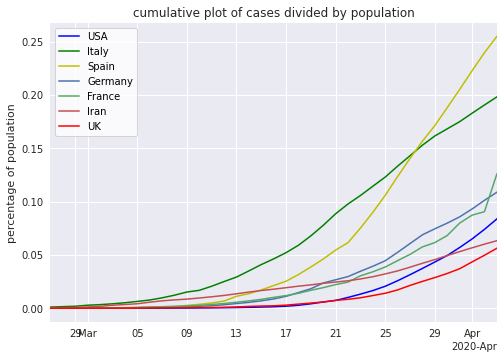

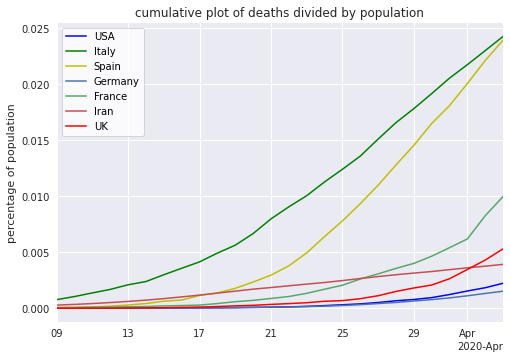

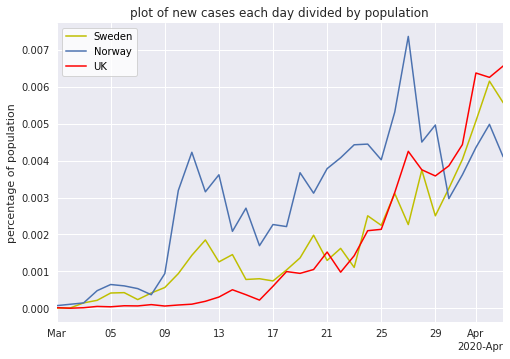

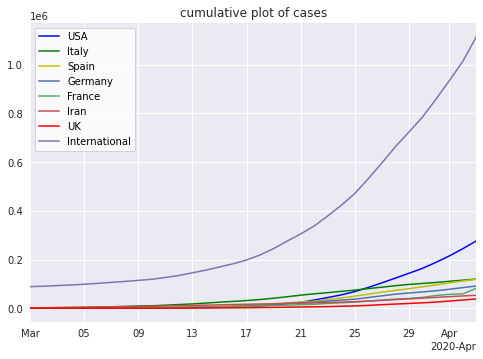

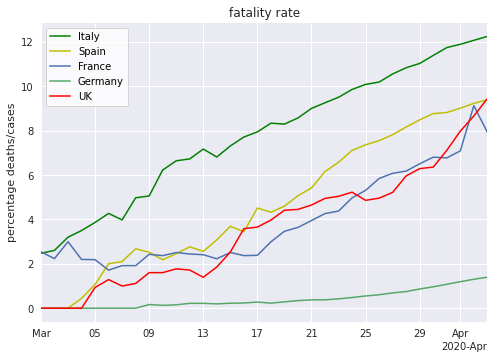

In [575]:
plot('cumulative',['United States','Italy','Spain','Germany','France','Iran','United Kingdom'],'cases',divideBy_population=True,date_min_index=48)
plot('cumulative',['United States','Italy','Spain','Germany','France','Iran','United Kingdom'],'deaths',divideBy_population=True,date_min_index=48)
plot('new',['Sweden','Norway','United Kingdom'],'cases',divideBy_population=True,date_min_index=-34)
plot('cumulative',['United States','Italy','Spain','Germany','France','Iran','United Kingdom','International'],'cases',divideBy_population=False,date_min_index=-34)
plot('fatality rate',['Italy','Spain','France','Germany','United Kingdom'],cases_or_deaths=None,date_min_index=-34)

# My First Theory after looking at the data

The above chart seems to show a trend that every day, the number of new cases,N ~ 30% (R) of total cases over 10 days previously.

\begin{equation*}
    N(X) = \left(R \sum_{x=-10}^{0}N(x) \right) 
\end{equation*}
where k is in days

In [547]:
yvals_governement_effect[uk_index][45:]

NameError: name 'yvals_governement_effect' is not defined

In [ ]:
#start from first value:
R = np.mean(yvals_governement_effect[uk_index][47:])/100
print(R)

In [ ]:
predictions = np.zeros(shape =(14,2),dtype='object')

for i,row in enumerate(predictions):
    row[0] = np.datetime64(dates[-10], 'D') + np.timedelta64(i, 'D')
    row[1] = yvals_[uk_index][-10+i] 
    if i == 10:
        row[1] += R*(yvals_[uk_index][-1]- yvals_[uk_index][-10]) + predictions[i-1][1]
    elif i > 10:
        row[1] += R*(predictions[i-1][1] - yvals_[uk_index][i-20]) + predictions[i-1][1]


predictions